In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [7]:
num_qubits_head = 9  # 7 qubit per il primo circuito
num_qubits_tail = 8  # 6 qubit per il secondo circuito
n_a_qubits = 1  # 1 qubit ancilla

device1 = qml.device("default.qubit", wires=num_qubits_head)
device2 = qml.device("default.qubit", wires=num_qubits_tail)

@qml.qnode(device1)
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_head))
    return qml.probs(wires=range(num_qubits_head))

@qml.qnode(device2)
def quantum_circuit1(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits_tail), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits_tail))
    return qml.probs(wires=range(num_qubits_tail))

class QuantumDenoiser(nn.Module):
    def __init__(self, n_layers=10):
        super().__init__()
        self.n_qubits = num_qubits_head
        self.n_qubits1 = num_qubits_tail
        self.n_a_qubits = n_a_qubits
        
        weight_shapes = {"weights": (n_layers, num_qubits_head, 3)}
        weight_shapes1 = {"weights": (n_layers, num_qubits_tail, 3)}
        
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.qlayer1 = qml.qnn.TorchLayer(quantum_circuit1, weight_shapes1)

    def forward(self, x):
        probs = self.qlayer(x.unsqueeze(0))
        probsgiven0 = probs[:, : (2 ** (self.n_qubits - self.n_a_qubits))]
        probsgiven0 /= torch.sum(probs)
        return self.qlayer1(probsgiven0)

In [10]:
num_qubits = 8
dev = qml.device("default.mixed", wires=num_qubits)

@qml.qnode(dev)
def mnist_to_quantum_state(image_vector, noise_param):
    qml.AmplitudeEmbedding(image_vector, wires=range(num_qubits), normalize=True)
    for i in range(num_qubits):
        qml.DepolarizingChannel(noise_param, wires=i)
    return qml.state()

def reconstruct_image(density_matrix):
    amplitudes = np.sqrt(np.real(np.diag(density_matrix)))
    amplitudes = amplitudes / np.linalg.norm(amplitudes)
    return amplitudes.reshape(16, 16)

# Carica e prepara l'immagine MNIST
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
index = 0
image, label = mnist_dataset[index]
image_flat = image.numpy().flatten()
image_normalized = image_flat / np.linalg.norm(image_flat)

Step: 1, Noise: 0.025, Purity: 0.694589
Step: 2, Noise: 0.050, Purity: 0.481969
Step: 3, Noise: 0.075, Purity: 0.334483
Step: 4, Noise: 0.100, Purity: 0.232497
Step: 5, Noise: 0.125, Purity: 0.162150
Step: 6, Noise: 0.150, Purity: 0.113710
Step: 7, Noise: 0.175, Purity: 0.080382
Step: 8, Noise: 0.200, Purity: 0.057445
Step: 9, Noise: 0.225, Purity: 0.041635
Step: 10, Noise: 0.250, Purity: 0.030705
Step: 11, Noise: 0.275, Purity: 0.023113
Step: 12, Noise: 0.300, Purity: 0.017808
Step: 13, Noise: 0.325, Purity: 0.014071
Step: 14, Noise: 0.350, Purity: 0.011412
Step: 15, Noise: 0.375, Purity: 0.009500
Step: 16, Noise: 0.400, Purity: 0.008108
Step: 17, Noise: 0.425, Purity: 0.007080
Step: 18, Noise: 0.450, Purity: 0.006312
Step: 19, Noise: 0.475, Purity: 0.005730
Step: 20, Noise: 0.500, Purity: 0.005284
Step: 21, Noise: 0.525, Purity: 0.004939
Step: 22, Noise: 0.550, Purity: 0.004669
Step: 23, Noise: 0.575, Purity: 0.004458
Step: 24, Noise: 0.600, Purity: 0.004293
Step: 25, Noise: 0.625, P

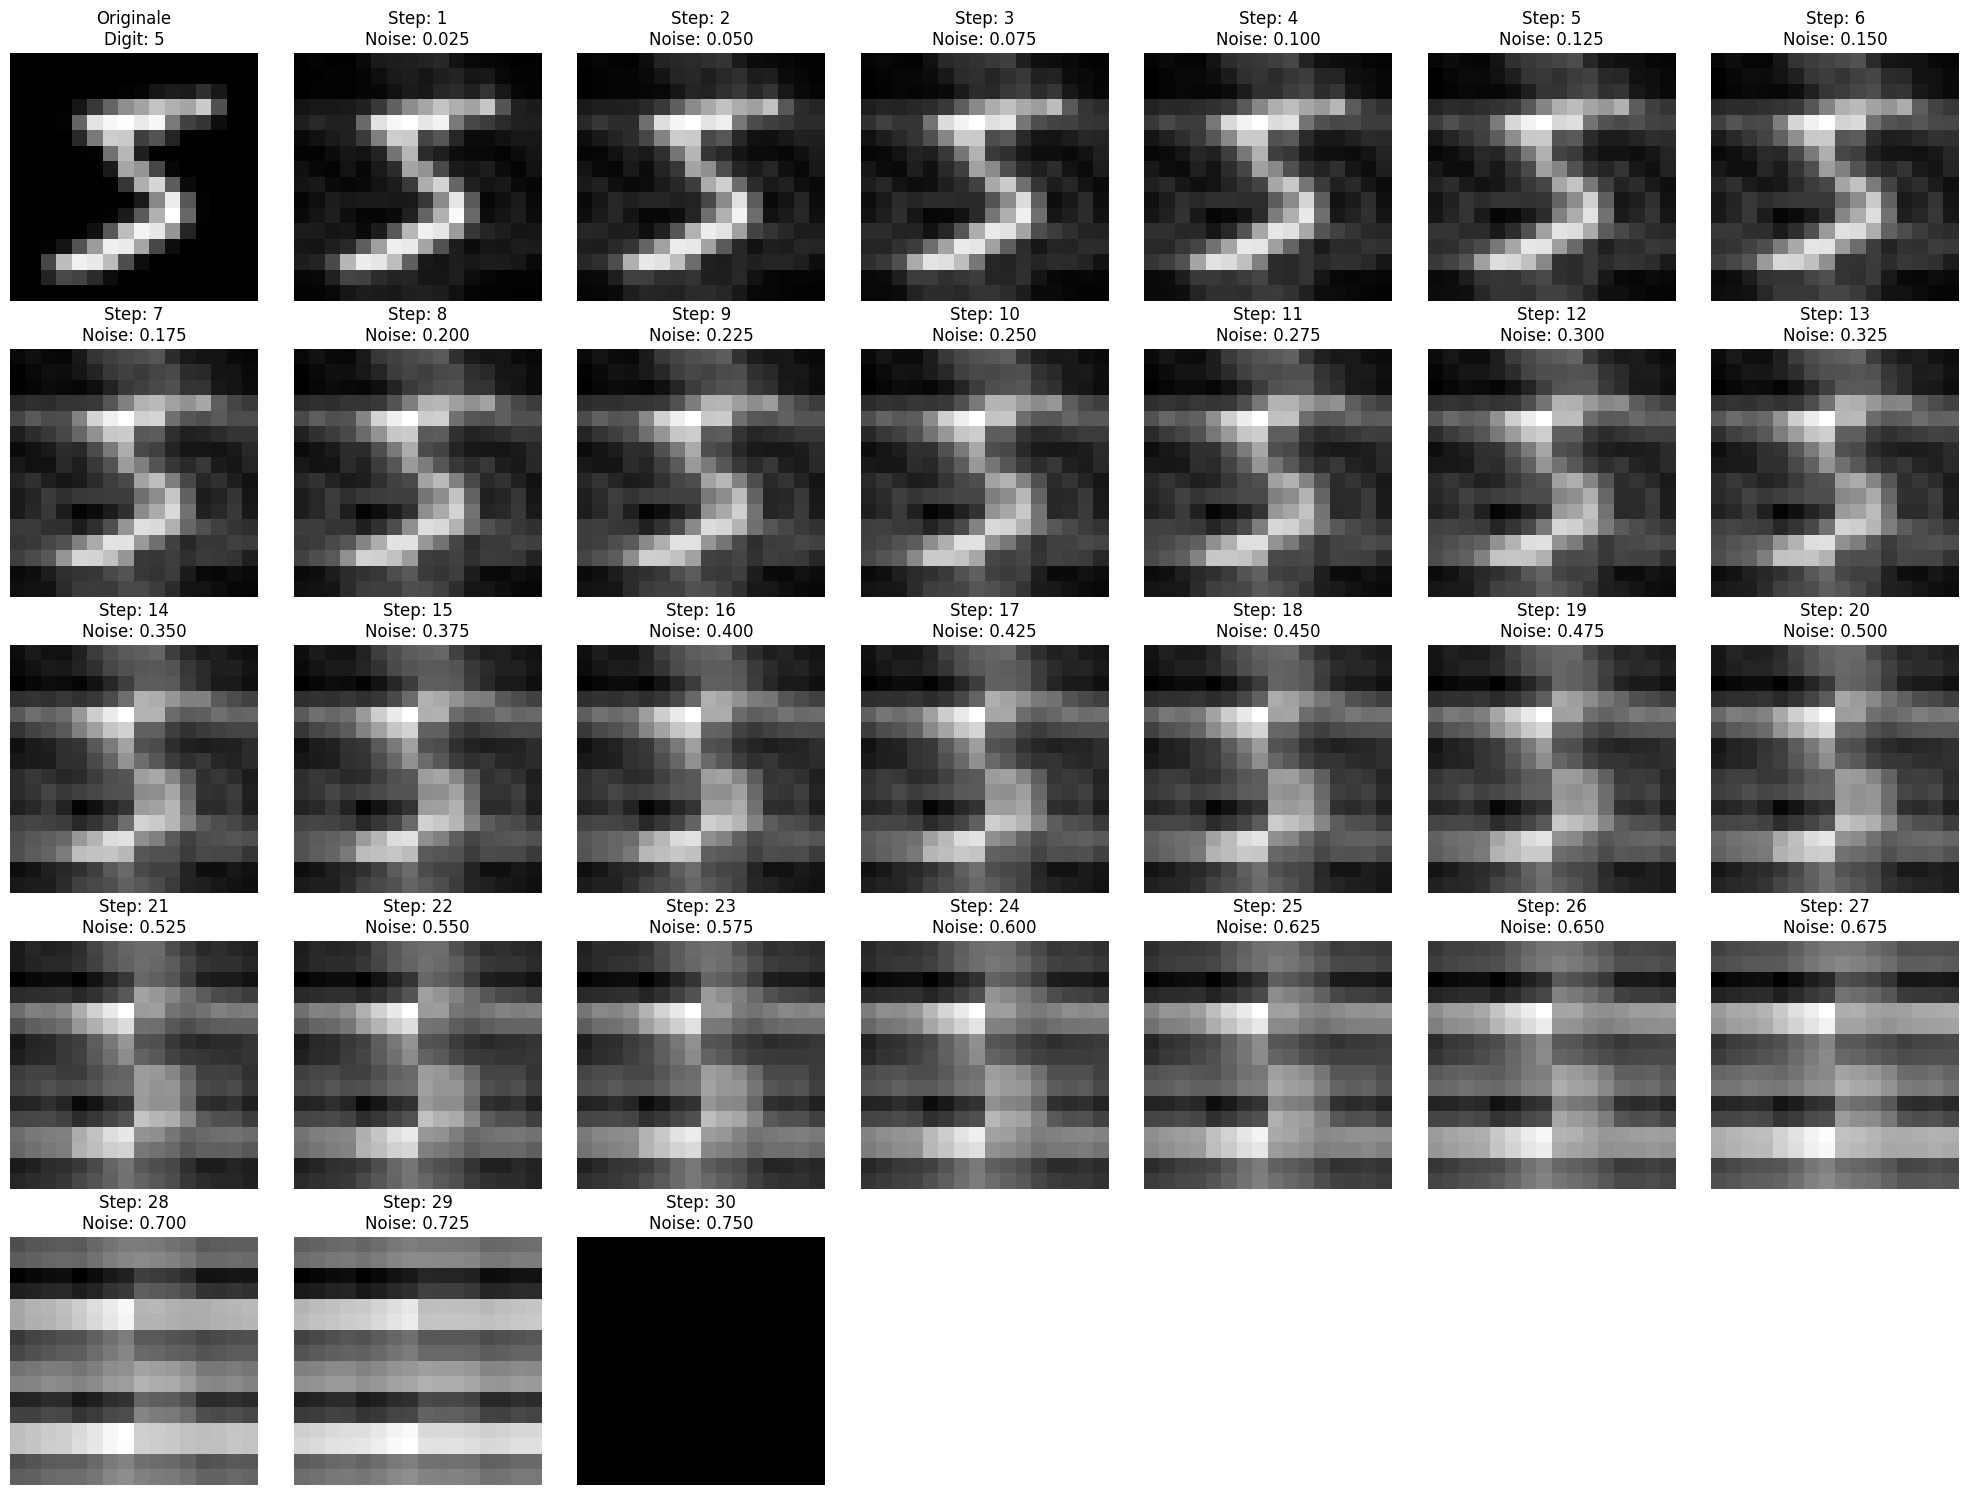

In [11]:
total_steps = 30
max_noise = 0.75


num_rows = 5
num_cols = 7
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Visualizza l'immagine originale
axes[0, 0].imshow(image.squeeze(), cmap='gray')
axes[0, 0].set_title(f"Originale\nDigit: {label}")
axes[0, 0].axis('off')
depolarized_images = []

# Applica il rumore gradualmente e visualizza i risultati
for step in range(total_steps):
    current_noise = max_noise * (step + 1) / total_steps
    density_matrix = mnist_to_quantum_state(image_normalized, current_noise)
    depolarized_image = reconstruct_image(density_matrix)
    depolarized_images.append(depolarized_image)
    row = (step + 1) // num_cols
    col = (step + 1) % num_cols
    axes[row, col].imshow(depolarized_image, cmap='gray')
    axes[row, col].set_title(f"Step: {step+1}\nNoise: {current_noise:.3f}")
    axes[row, col].axis('off')
    
    purity = np.real(np.trace(np.matmul(density_matrix, density_matrix)))
    print(f"Step: {step+1}, Noise: {current_noise:.3f}, Purity: {purity:.6f}")

# Rimuovi gli assi vuoti
for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j >= total_steps + 1:
            fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

In [16]:
model = QuantumDenoiser(n_layers=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    noisy_image = torch.tensor(depolarized_images[total_steps - 1].flatten())
    for step in range(total_steps - 1, 0, -1):
        target_image = torch.tensor(depolarized_images[step - 1].flatten())
        optimizer.zero_grad()
        denoised_image = model(noisy_image)
        loss = loss_fn(denoised_image.flatten(), target_image.flatten())
        loss.backward()
        optimizer.step()
        noisy_image = denoised_image.detach().flatten()
        total_loss += loss.item()
    
    avg_loss = total_loss / total_steps
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 0.003353
Epoch 2, Average Loss: 0.003323
Epoch 3, Average Loss: 0.003300
Epoch 4, Average Loss: 0.003278
Epoch 5, Average Loss: 0.003258
Epoch 6, Average Loss: 0.003245
Epoch 7, Average Loss: 0.003236
Epoch 8, Average Loss: 0.003229
Epoch 9, Average Loss: 0.003221
Epoch 10, Average Loss: 0.003214
Epoch 11, Average Loss: 0.003209
Epoch 12, Average Loss: 0.003205
Epoch 13, Average Loss: 0.003201
Epoch 14, Average Loss: 0.003197
Epoch 15, Average Loss: 0.003194
Epoch 16, Average Loss: 0.003192
Epoch 17, Average Loss: 0.003189
Epoch 18, Average Loss: 0.003187
Epoch 19, Average Loss: 0.003185
Epoch 20, Average Loss: 0.003184
Epoch 21, Average Loss: 0.003183
Epoch 22, Average Loss: 0.003182
Epoch 23, Average Loss: 0.003181
Epoch 24, Average Loss: 0.003180
Epoch 25, Average Loss: 0.003180
Epoch 26, Average Loss: 0.003179
Epoch 27, Average Loss: 0.003178
Epoch 28, Average Loss: 0.003177
Epoch 29, Average Loss: 0.003177
Epoch 30, Average Loss: 0.003176
Epoch 31, Average L

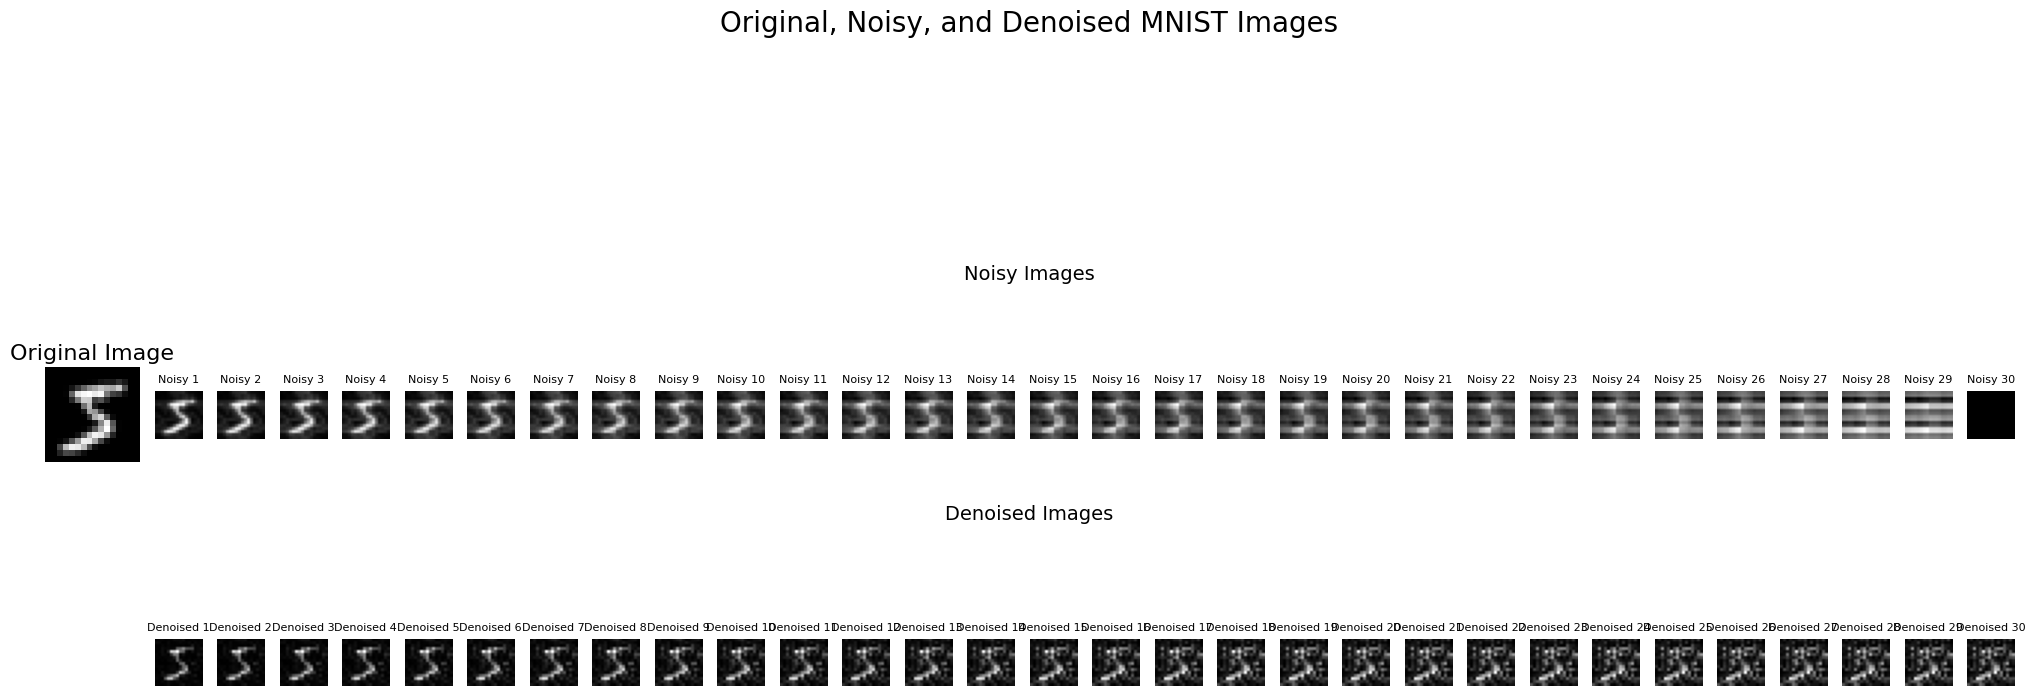

In [17]:
 # Creiamo un layout con l'immagine originale a sinistra e le altre a destra
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(3, total_steps + 1, width_ratios=[2] + [1]*total_steps)

    # Immagine originale
ax_original = fig.add_subplot(gs[:, 0])
ax_original.imshow(image.squeeze(), cmap='gray')
ax_original.set_title("Original Image", fontsize=16)
ax_original.axis('off')

    # Immagini rumorose e denoisate
for step in range(total_steps):
        # Immagine rumorosa
        ax_noisy = fig.add_subplot(gs[1, step + 1])
        ax_noisy.imshow(np.abs(depolarized_images[step]), cmap='gray')
        ax_noisy.set_title(f"Noisy {step+1}", fontsize=8)
        ax_noisy.axis('off')

        # Immagine denoised
        ax_denoised = fig.add_subplot(gs[2, step + 1])
        with torch.no_grad():
            noisy_image = torch.tensor(depolarized_images[step].flatten(), dtype=torch.float32)
            denoised_image = model(noisy_image).numpy().reshape(16, 16)
        ax_denoised.imshow(denoised_image, cmap='gray')
        ax_denoised.set_title(f"Denoised {step+1}", fontsize=8)
        ax_denoised.axis('off')

    # Aggiunge titoli alle righe
fig.text(0.5, 0.65, 'Noisy Images', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.35, 'Denoised Images', ha='center', va='center', fontsize=14)

plt.suptitle("Original, Noisy, and Denoised MNIST Images", fontsize=20)
plt.tight_layout()
plt.show()

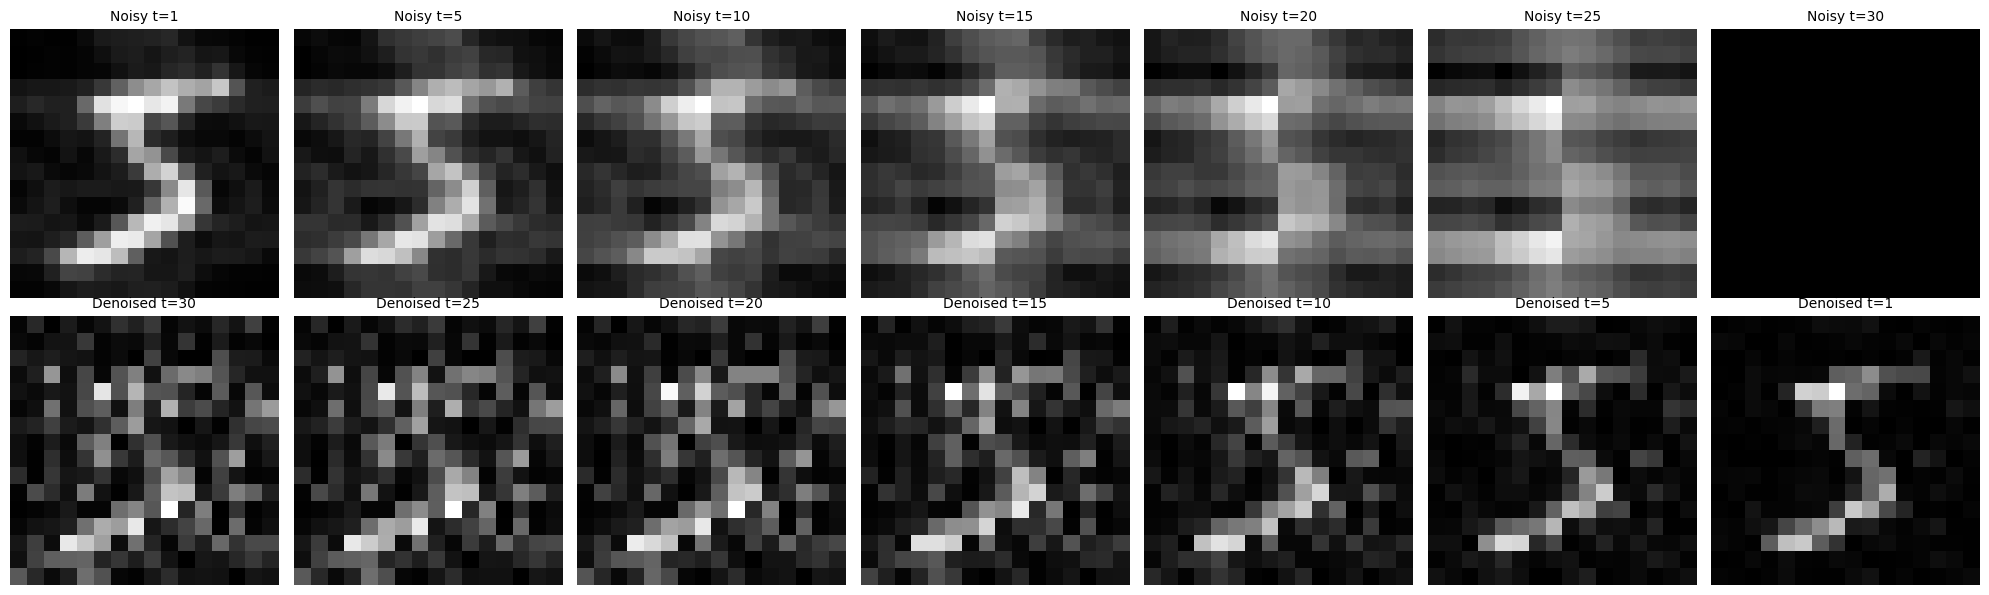

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Timestep specifici per le immagini rumorose e denoisate
noisy_timesteps = [1, 5, 10, 15, 20, 25, 30]
denoised_timesteps = [30, 25, 20, 15, 10, 5, 1]

# Creiamo un layout per le immagini rumorose e denoisate
fig, axs = plt.subplots(2, 7, figsize=(20, 6))

# Immagini rumorose e denoisate
for i, (noisy_step, denoised_step) in enumerate(zip(noisy_timesteps, denoised_timesteps)):
    # Immagine rumorosa
    axs[0, i].imshow(np.abs(depolarized_images[noisy_step - 1]), cmap='gray')
    axs[0, i].set_title(f"Noisy t={noisy_step}", fontsize=10)
    axs[0, i].axis('off')

    # Immagine denoised
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[denoised_step - 1].flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image).numpy().reshape(16, 16)
    axs[1, i].imshow(denoised_image, cmap='gray')
    axs[1, i].set_title(f"Denoised t={denoised_step}", fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
def calculate_fidelity(state1, state2):
   state1 = qml.math.dm_from_state_vector(state1)
   state2 = qml.math.dm_from_state_vector(state2)
   return qml.math.fidelity(state1, state2)

# Calcola e stampa la fidelity tra l'immagine originale e quella denoised per ogni step
original_state = torch.tensor(image_normalized.flatten(), dtype=torch.complex64)
original_state = original_state / torch.norm(original_state)

for step in range(total_steps):
    with torch.no_grad():
        noisy_image = torch.tensor(np.abs(depolarized_images[step]).flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image)
        # Converti a complesso per il calcolo della fidelity
        denoised_state = denoised_image.to(torch.complex64)
        denoised_state = denoised_state / torch.norm(denoised_state)
    fidelity = calculate_fidelity(denoised_state.flatten(), original_state)
    print(f"Step {step+1}, Fidelity: {fidelity:.6f}")

Step 1, Fidelity: 0.846524
Step 2, Fidelity: 0.835067
Step 3, Fidelity: 0.821956
Step 4, Fidelity: 0.807636
Step 5, Fidelity: 0.792290
Step 6, Fidelity: 0.776084
Step 7, Fidelity: 0.759206
Step 8, Fidelity: 0.741862
Step 9, Fidelity: 0.724273
Step 10, Fidelity: 0.706662
Step 11, Fidelity: 0.689243
Step 12, Fidelity: 0.672213
Step 13, Fidelity: 0.655746
Step 14, Fidelity: 0.639982
Step 15, Fidelity: 0.625035
Step 16, Fidelity: 0.610989
Step 17, Fidelity: 0.597897
Step 18, Fidelity: 0.585792
Step 19, Fidelity: 0.574687
Step 20, Fidelity: 0.564579
Step 21, Fidelity: 0.555455
Step 22, Fidelity: 0.547296
Step 23, Fidelity: 0.540077
Step 24, Fidelity: 0.533771
Step 25, Fidelity: 0.528353
Step 26, Fidelity: 0.523796
Step 27, Fidelity: 0.520074
Step 28, Fidelity: 0.517164
Step 29, Fidelity: 0.515042
Step 30, Fidelity: 0.513686


In [20]:
class ClassicalDenoiser(nn.Module):
    def __init__(self, input_size=256, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        return self.model(x)

# Inizializzazione del modello e dell'ottimizzatore
model = ClassicalDenoiser()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Assumiamo che depolarized_images e image_normalized siano già definiti
total_steps = len(depolarized_images)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    noisy_image = torch.tensor(np.abs(depolarized_images[total_steps - 1]).flatten(), dtype=torch.float32)
    for step in range(total_steps - 1, 0, -1):
        target_image = torch.tensor(np.abs(depolarized_images[step - 1]).flatten(), dtype=torch.float32)
        optimizer.zero_grad()
        denoised_image = model(noisy_image)
        loss = loss_fn(denoised_image.flatten(), target_image)
        loss.backward()
        optimizer.step()
        noisy_image = denoised_image.detach().flatten()
        total_loss += loss.item()
    
    avg_loss = total_loss / total_steps
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.6f}")

Epoch 1, Average Loss: 0.001889
Epoch 2, Average Loss: 0.000575
Epoch 3, Average Loss: 0.000422
Epoch 4, Average Loss: 0.000371
Epoch 5, Average Loss: 0.000373
Epoch 6, Average Loss: 0.000379
Epoch 7, Average Loss: 0.000391
Epoch 8, Average Loss: 0.000408
Epoch 9, Average Loss: 0.000364
Epoch 10, Average Loss: 0.000358
Epoch 11, Average Loss: 0.000364
Epoch 12, Average Loss: 0.000345
Epoch 13, Average Loss: 0.000358
Epoch 14, Average Loss: 0.000348
Epoch 15, Average Loss: 0.000362
Epoch 16, Average Loss: 0.000337
Epoch 17, Average Loss: 0.000344
Epoch 18, Average Loss: 0.000332
Epoch 19, Average Loss: 0.000332
Epoch 20, Average Loss: 0.000327
Epoch 21, Average Loss: 0.000321
Epoch 22, Average Loss: 0.000341
Epoch 23, Average Loss: 0.000335
Epoch 24, Average Loss: 0.000324
Epoch 25, Average Loss: 0.000315
Epoch 26, Average Loss: 0.000314
Epoch 27, Average Loss: 0.000323
Epoch 28, Average Loss: 0.000381
Epoch 29, Average Loss: 0.000321
Epoch 30, Average Loss: 0.000319
Epoch 31, Average L

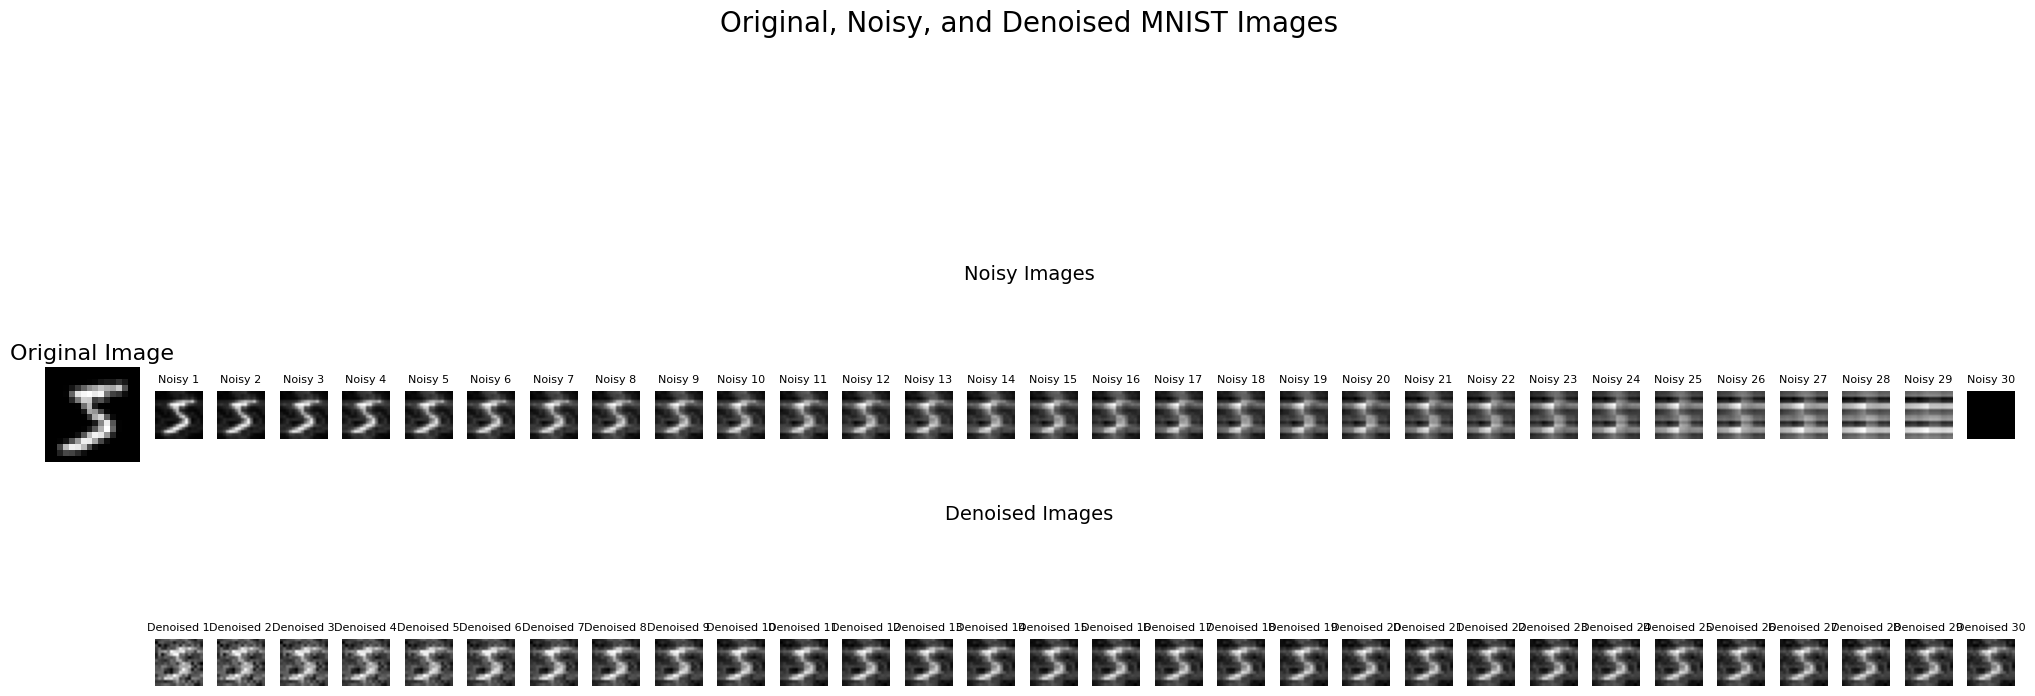

In [22]:
 # Creiamo un layout con l'immagine originale a sinistra e le altre a destra
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(3, total_steps + 1, width_ratios=[2] + [1]*total_steps)

    # Immagine originale
ax_original = fig.add_subplot(gs[:, 0])
ax_original.imshow(image.squeeze(), cmap='gray')
ax_original.set_title("Original Image", fontsize=16)
ax_original.axis('off')

    # Immagini rumorose e denoisate
for step in range(total_steps):
        # Immagine rumorosa
        ax_noisy = fig.add_subplot(gs[1, step + 1])
        ax_noisy.imshow(np.abs(depolarized_images[step]), cmap='gray')
        ax_noisy.set_title(f"Noisy {step+1}", fontsize=8)
        ax_noisy.axis('off')

        # Immagine denoised
        ax_denoised = fig.add_subplot(gs[2, step + 1])
        with torch.no_grad():
            noisy_image = torch.tensor(np.abs(depolarized_images[step]).flatten(), dtype=torch.float32)
            denoised_image = model(noisy_image).numpy().reshape(16, 16)
        ax_denoised.imshow(denoised_image, cmap='gray')
        ax_denoised.set_title(f"Denoised {step+1}", fontsize=8)
        ax_denoised.axis('off')

    # Aggiunge titoli alle righe
fig.text(0.5, 0.65, 'Noisy Images', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.35, 'Denoised Images', ha='center', va='center', fontsize=14)

plt.suptitle("Original, Noisy, and Denoised MNIST Images", fontsize=20)
plt.tight_layout()
plt.show()

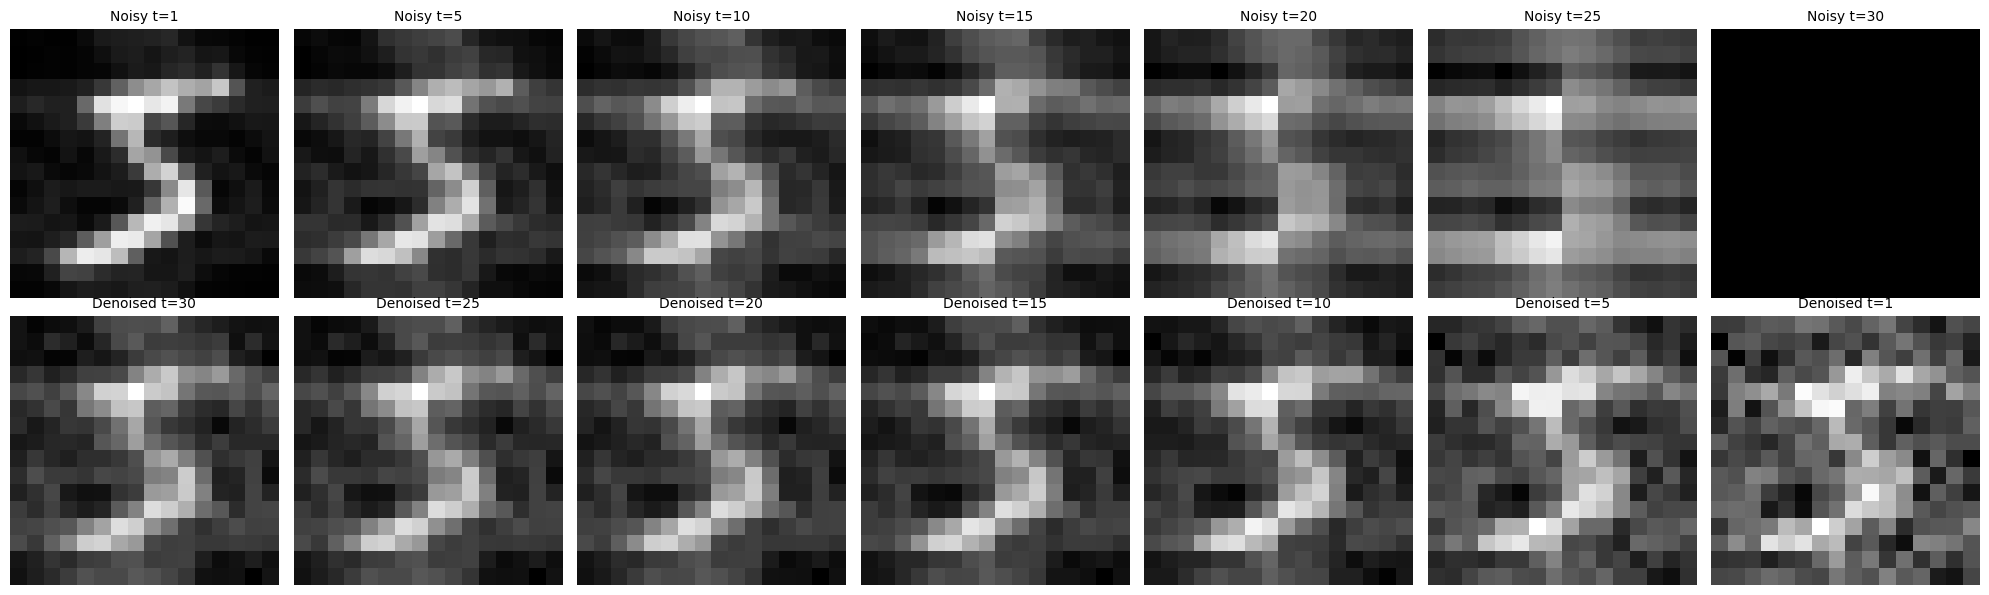

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Timestep specifici per le immagini rumorose e denoisate
noisy_timesteps = [1, 5, 10, 15, 20, 25, 30]
denoised_timesteps = [30, 25, 20, 15, 10, 5, 1]

# Creiamo un layout per le immagini rumorose e denoisate
fig, axs = plt.subplots(2, 7, figsize=(20, 6))

# Immagini rumorose e denoisate
for i, (noisy_step, denoised_step) in enumerate(zip(noisy_timesteps, denoised_timesteps)):
    # Immagine rumorosa
    axs[0, i].imshow(np.abs(depolarized_images[noisy_step - 1]), cmap='gray')
    axs[0, i].set_title(f"Noisy t={noisy_step}", fontsize=10)
    axs[0, i].axis('off')

    # Immagine denoised
    with torch.no_grad():
        noisy_image = torch.tensor(depolarized_images[denoised_step - 1].flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image).numpy().reshape(16, 16)
    axs[1, i].imshow(denoised_image, cmap='gray')
    axs[1, i].set_title(f"Denoised t={denoised_step}", fontsize=10)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [44]:
# Calcola e stampa la fidelity tra l'immagine originale e quella denoised per ogni step
original_state = torch.tensor(image_normalized.flatten(), dtype=torch.float32)
original_state = original_state / torch.norm(original_state)

for step in range(total_steps):
    with torch.no_grad():
        noisy_image = torch.tensor(np.abs(depolarized_images[step]).flatten(), dtype=torch.float32)
        denoised_image = model(noisy_image)
        denoised_state = denoised_image / torch.norm(denoised_image)
    fidelity = calculate_fidelity(denoised_state, original_state)
    print(f"Step {step+1}, Fidelity: {fidelity:.6f}")

Step 1, Fidelity: 0.554265
Step 2, Fidelity: 0.563409
Step 3, Fidelity: 0.569080
Step 4, Fidelity: 0.572971
Step 5, Fidelity: 0.575542
Step 6, Fidelity: 0.577341
Step 7, Fidelity: 0.578607
Step 8, Fidelity: 0.579458
Step 9, Fidelity: 0.580302
Step 10, Fidelity: 0.581034
Step 11, Fidelity: 0.581542
Step 12, Fidelity: 0.581859
Step 13, Fidelity: 0.582011
Step 14, Fidelity: 0.582020
Step 15, Fidelity: 0.581904
Step 16, Fidelity: 0.581680
Step 17, Fidelity: 0.581362
Step 18, Fidelity: 0.580962
Step 19, Fidelity: 0.580495
Step 20, Fidelity: 0.579972
Step 21, Fidelity: 0.579405
Step 22, Fidelity: 0.578807
Step 23, Fidelity: 0.578190
Step 24, Fidelity: 0.577567
Step 25, Fidelity: 0.576950
Step 26, Fidelity: 0.576351
Step 27, Fidelity: 0.575782
Step 28, Fidelity: 0.575252
Step 29, Fidelity: 0.574772
Step 30, Fidelity: 0.574347
